# PROBLEM STATEMENT

Develop a robust and accurate model to able to predict if a certain individual is eligible for a loan.

# DOWNLOAD DATASET

In [1]:
!pip install kaggle

In [2]:
!kaggle datasets download taweilo/loan-approval-classification-data

Dataset URL: https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data
License(s): apache-2.0
  0% 0.00/751k [00:00<?, ?B/s]
100% 751k/751k [00:00<00:00, 35.6MB/s]


In [3]:
!unzip /content/loan-approval-classification-data.zip

Archive:  /content/loan-approval-classification-data.zip
  inflating: loan_data.csv           


# PREPROCESSING

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df=pd.read_csv('/content/loan_data.csv')
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [5]:
df['loan_status'].value_counts()

,count
loan_status,
0,35000
1,10000


Data unbalanced, hence we got the remove 25k rows with the label of 0.

In [6]:
for items in df[df['loan_status']==0] [:25000].index:
  df.drop(items, inplace=True) #dropping the first 25k samples with label 0

In [7]:
#enocde certain columns
from sklearn.preprocessing import LabelEncoder
for col in df.columns:
  if df[col].dtype == 'object':
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col])


In [8]:
df

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,0,4,71948.0,0,3,35000.0,4,16.02,0.49,3.0,561,0,1
2,25.0,0,3,12438.0,3,0,5500.0,3,12.87,0.44,3.0,635,0,1
3,23.0,0,1,79753.0,0,3,35000.0,3,15.23,0.44,2.0,675,0,1
4,24.0,1,4,66135.0,1,3,35000.0,3,14.27,0.53,4.0,586,0,1
5,21.0,0,3,12951.0,0,2,2500.0,5,7.14,0.19,2.0,532,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,27.0,1,0,47971.0,6,3,15000.0,3,15.66,0.31,3.0,645,0,1
44996,37.0,0,0,65800.0,17,3,9000.0,2,14.07,0.14,11.0,621,0,1
44997,33.0,1,0,56942.0,7,3,2771.0,0,10.02,0.05,10.0,668,0,1
44998,29.0,1,1,33164.0,4,3,12000.0,1,13.23,0.36,6.0,604,0,1


In [9]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']


The data is in a pandas dataframe, and we need to get it to a pytorch tensor.

In [10]:
X.shape

(20000, 13)

In [11]:
y.shape

(20000,)

In [12]:
#split the model before scaling
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
#scale the model
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
#after scaling, they are numpy arrays, change them to tensors
import torch
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

#MODEL

In [15]:
#model acrhitectrue
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils

class Classiffier(torch.nn.Module):
    def __init__(self):
        super(Classiffier, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
      x = torch.relu(self.fc1(x))
      x = torch.relu(self.fc2(x))
      x = torch.sigmoid(self.fc3(x))
      return x


In [16]:
model = Classiffier()
criterion = nn.BCEWithLogitsLoss() #for binary loss
optimizer = optim.Adam(model.parameters(), lr=0.0001)


#TRAINING

In [20]:
#load the train
train_dataset = data_utils.TensorDataset(X_train, y_train)
train_loader = data_utils.DataLoader(train_dataset, batch_size=32, shuffle=True)

epochs = 100
Loss = []
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
    Loss.append(loss.item())

    if epoch  % 10 == 0:  # Print every epochs
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

Epoch 1/100, Loss: 0.6351
Epoch 11/100, Loss: 0.5920
Epoch 21/100, Loss: 0.5744
Epoch 31/100, Loss: 0.5957
Epoch 41/100, Loss: 0.5893
Epoch 51/100, Loss: 0.6022
Epoch 61/100, Loss: 0.6025
Epoch 71/100, Loss: 0.5531
Epoch 81/100, Loss: 0.5542
Epoch 91/100, Loss: 0.5830


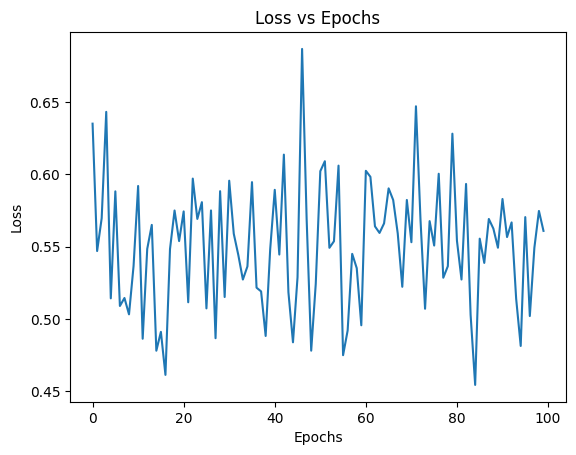

In [21]:
plt.plot(Loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.show()

Losses flatuating due to batchs being less or more challenging but overall, its decreasing.

#EVALUATION

In [18]:
import torch.utils.data as data_utils


# load the data with batch size
test_dataset = data_utils.TensorDataset(X_test, y_test)
test_loader = data_utils.DataLoader(test_dataset, batch_size=32, shuffle=False)

#evaluate
model.eval()
with torch.no_grad():
    total_correct = 0
    total_samples = 0
    for data, target in test_loader:
        outputs = model(data)
        predicted = (outputs > 0.5).float()

        # Count correct predictions for this batch
        total_correct += (predicted == target).sum().item()
        total_samples += target.size(0)

    # Calculate overall accuracy
    accuracy = total_correct / total_samples
    print(f'Unseeen Data Accuracy: {accuracy}')

Unseeen Data Accuracy: 0.88975


In [19]:
from sklearn.metrics import classification_report

model.eval()
with torch.no_grad():
    all_predicted = []
    all_targets = []
    for data, target in test_loader:
        outputs = model(data)
        predicted = (outputs > 0.5).float()

        all_predicted.extend(predicted.cpu().numpy())  #y_pred
        all_targets.extend(target.cpu().numpy())  #y_true


    report = classification_report(all_targets, all_predicted)
    print(report)

              precision    recall  f1-score   support

         0.0       0.87      0.92      0.89      2015
         1.0       0.92      0.85      0.88      1985

    accuracy                           0.89      4000
   macro avg       0.89      0.89      0.89      4000
weighted avg       0.89      0.89      0.89      4000



# HYPERPARAMETER TUNING


In [34]:
#function to try all combinations of hyperparameters and return best one
def hyperparameter_tuning(model):
  #define all the hyperpaarameters in lists
  loss_selections =[nn.BCELoss(), nn.BCEWithLogitsLoss()]
  optimizer_selections = [optim.Adam, optim.SGD, optim.RMSprop]
  lr_selections = [0.0001, 0.001, 0.01]
  batch_selections = [32, 64, 128]
  #training
  epochs = 100
  best_accuracy = 0
  best_params = ""
  #nested forloop to go through all combinations
  for loss_selection in loss_selections:
    for optimizer_selection in optimizer_selections:
      for lr_selection in lr_selections:
        for batch_selection in batch_selections:
          model = Classiffier()
          criterion = loss_selection
          optimizer = optimizer_selection(model.parameters(), lr=lr_selection)
          train_dataset = data_utils.TensorDataset(X_train, y_train)
          train_loader = data_utils.DataLoader(train_dataset, batch_size=batch_selection, shuffle=True)
          for epoch in range(epochs):
            for batch_idx, (data, target) in enumerate(train_loader):
              optimizer.zero_grad()
              outputs = model(data)
              loss = criterion(outputs, target)
              loss.backward()
              optimizer.step()
          #testing
          model.eval()
          with torch.no_grad():
            total_correct = 0
            total_samples = 0
            for data, target in test_loader:
              outputs = model(data)
              predicted = (outputs > 0.5).float()

              # accuracy
              total_correct += (predicted == target).sum().item()
              total_samples += target.size(0)
            accuracy = total_correct / total_samples
            info = (f'''
              __________________________________
              Loss: {loss_selection},
              Optimizer: {optimizer_selection},
              Learning Rate: {lr_selection},
              Batch Size: {batch_selection},
              Unseeen Data Accuracy: {accuracy}
              __________________________________
                  ''')
            #updating best parameters
            if accuracy > best_accuracy:
              best_accuracy = accuracy
              best_params = info
  return best_params


In [36]:
print(hyperparameter_tuning(model)) #see the progression


              __________________________________
              Loss: BCELoss(),
              Optimizer: <class 'torch.optim.adam.Adam'>, 
              Learning Rate: 0.0001,
              Batch Size: 32,
              Unseeen Data Accuracy: 0.89625
              __________________________________    
                  

              __________________________________
              Loss: BCELoss(),
              Optimizer: <class 'torch.optim.adam.Adam'>, 
              Learning Rate: 0.0001,
              Batch Size: 64,
              Unseeen Data Accuracy: 0.8985
              __________________________________    
                  

              __________________________________
              Loss: BCELoss(),
              Optimizer: <class 'torch.optim.adam.Adam'>, 
              Learning Rate: 0.001,
              Batch Size: 128,
              Unseeen Data Accuracy: 0.9
              __________________________________    
                  

              __________________

# FINETUNING

Bsed on the hyperparameter function, we are updating the hyperparameter to obtain the best accuracy

In [39]:
model_tuned = Classiffier()
criterion = nn.BCELoss() #for binrary loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_tuned = data_utils.DataLoader(train_dataset, batch_size=128, shuffle=True)

epochs = 100
Loss = []
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_tuned):
        optimizer.zero_grad()
        outputs = model_tuned(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
    Loss.append(loss.item())

    if epoch  % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')





Epoch 1/100, Loss: 0.6624
Epoch 11/100, Loss: 0.6957
Epoch 21/100, Loss: 0.7037
Epoch 31/100, Loss: 0.6726
Epoch 41/100, Loss: 0.6816
Epoch 51/100, Loss: 0.6754
Epoch 61/100, Loss: 0.6887
Epoch 71/100, Loss: 0.6972
Epoch 81/100, Loss: 0.6776
Epoch 91/100, Loss: 0.7183


In [42]:
model_tuned.eval()
with torch.no_grad():
    total_correct = 0
    total_samples = 0
    for data, target in test_loader:
        outputs = model(data)
        predicted = (outputs > 0.5).float()

        # Count correct predictions for this batch
        total_correct += (predicted == target).sum().item()
        total_samples += target.size(0)

    # accuracy
    accuracy = total_correct / total_samples
    print(f'Unseeen Data Accuracy: {round(accuracy,2)}')

Unseeen Data Accuracy: 0.9


In [43]:
model_tuned.eval()
with torch.no_grad():
    all_predicted = []
    all_targets = []
    for data, target in test_loader:
        outputs = model(data)
        predicted = (outputs > 0.5).float()

        all_predicted.extend(predicted.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

    report = classification_report(all_targets, all_predicted)
    print(report)

              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90      2015
         1.0       0.90      0.90      0.90      1985

    accuracy                           0.90      4000
   macro avg       0.90      0.90      0.90      4000
weighted avg       0.90      0.90      0.90      4000



Improved precision and f1 for all classes but recall in class 0 decreased.